In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import DataLogger

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *
mcmc = mcmc_multi_site_variable_reflect_p

In [3]:
N_steps = 1000
N = 50
beta = 1/10
U = 0
J = 5
mu = 4
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
N_steps = 100
N_burn_in = 0

#log = FK_mcmc_random_pair(
log = mcmc(
    state,            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = DataLogger(), normalise = True,
    )
print(f'mcmc step acceptance probability = {log.p_acc*100}%')
print('done!')

mcmc step acceptance probability = 41.88%
done!


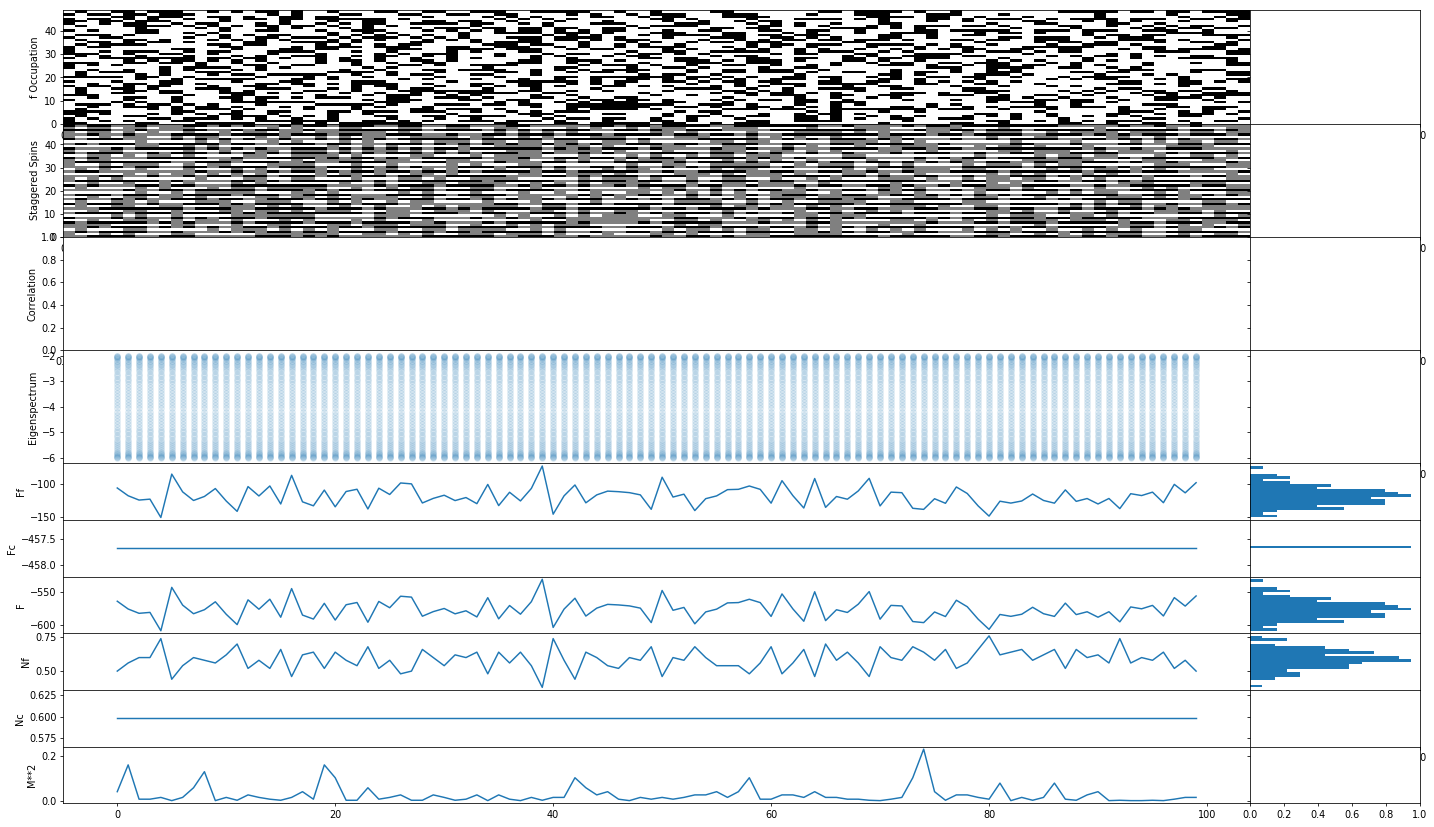

In [4]:
steps = np.arange(log.N_steps)
sites = np.arange(log.N_sites)

f, axes = plt.subplots(10,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))

axs, axs1 = axes.T
observables = [_, _, _, _, log.Ff, log.Fc, log.Ff + log.Fc, log.Nf, log.Nc, log.Mf_moments[2], log.cMf_moments[2]]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum',
                      'Ff', 'Fc', 'F', 'Nf', 'Nc', 'M**2', '(M-M_bar)**2']

axs[0].pcolor(steps, sites, log.state.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, (log.state * log.A).T, cmap = 'gray', vmin = -1, vmax = 1)
#axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(log.eigenvals), [-1,])
y = np.reshape(log.eigenvals, [-1])
axs[3].scatter(x, y, alpha = 0.1,)

for ax,observable in list(zip(axs,observables))[4:]: ax.plot(steps, observable)

#axs1[0].plot(r.states.mean(axis=0), sites)
#axs1[1].plot(r.ts.mean(axis=0), sites)
#axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
#axs1[3].plot(r.q_energy_histogram / np.sum(r.q_energy_histogram), r.q_energy_histogram_bins[:-1])

for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

In [5]:
##compare to montecarlo
from direct_partition_functions import direct, states_to_numbers, number_to_state, enumerate_states
from montecarlo import *

N = 4
beta = 1/10
U = 1
J = 5
mu = 4
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
mcmc_steps = np.array([1e2,1e3,1e4], dtype = np.int)
N_steps = max(mcmc_steps)
N_burn_in = 0

ix, state_labels, states, Ffs, Fcs, Nfs, Ncs, Mf_moments = enumerate_states(N, mu, beta, U, J, t, alpha, normalise = True)
Boltz_factors = np.exp(- beta * (Ffs + Fcs))
Ps = Boltz_factors / np.sum(Boltz_factors)

#calculate the thermodynamic means
Fc, Ff, Nf, Nc = np.sum(np.array([Fcs, Ffs, Nfs, Ncs]) * Ps[None, :], axis = 1) 
Ff = np.sum(Ffs * Ps)
Mf_moment = np.sum(Mf_moments*Ps[None, :], axis = 1)

#log = FK_mcmc(
#log = FK_mcmc_random_pair(
#log = FK_mcmc_multi_site(
log =  mcmc(
    state=np.zeros(N),            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = DataLogger(), normalise = True, N_multi_site = 4,
    )

mc_state_labels = states_to_numbers(log.state)
mc_label_count = np.bincount(mc_state_labels, minlength = 2**N)

#reorder the states into order of increasing energy
mc_label_count = mc_label_count[ix]/np.sum(mc_label_count)

mc_energies = log.Ff + log.Fc
print(f'p_acc = {log.p_acc}')
print(f'p_facc = {log.p_acc/log.p_facc}')

Warning, p_acc = 0.734225, mu = 4, beta = 0.1, J = 5
p_acc = 0.734225
p_facc = 0.9701384071614971


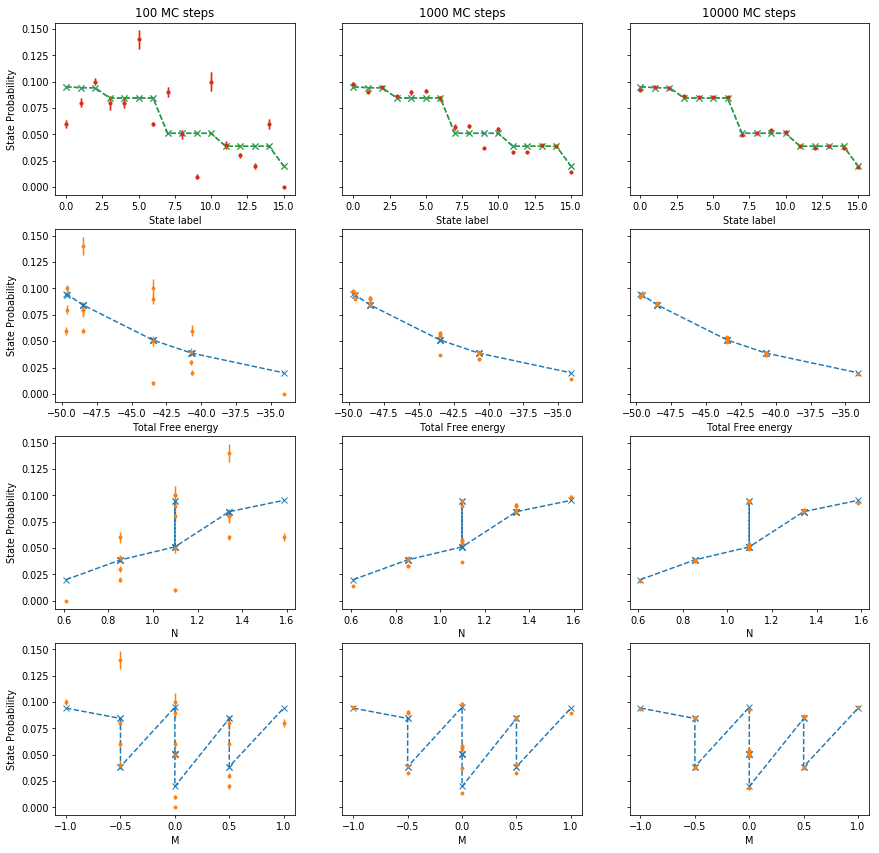

In [6]:
f, axes = plt.subplots(4,len(mcmc_steps), figsize = (5*len(mcmc_steps), 5*3), sharey = 'row')
for N_mc_steps, ax in zip(mcmc_steps, axes.T):

    #don't use the whole mcmc run, just the first N_mc_steps to see if it's converging
    chunksize = int(N_mc_steps/5)
    chunks = mc_state_labels[:N_mc_steps].reshape(-1,chunksize)
    binned_chunks = np.array([np.bincount(chunk, minlength = 2**N) for chunk in chunks])
    dmc_label_count = scipy.stats.sem(binned_chunks, axis = 0)
    
    mc_label_count = np.bincount(mc_state_labels[:N_mc_steps], minlength = 2**N)
    mc_label_count = mc_label_count[ix]
    dmc_label_count = dmc_label_count[ix]
    
    ax[0].set(title = f'{N_mc_steps} MC steps', xlabel = 'state label')
    
    ax[0].plot(np.arange(2**N), Ps, '--x')
    ax[0].errorbar(np.arange(2**N), mc_label_count/np.sum(mc_label_count),
                yerr= dmc_label_count/np.sum(mc_label_count), fmt = '.')
    
    for a, x, xlabel in zip(ax, 
                            [np.arange(2**N), Ffs + Fcs, Nfs+Ncs, Mf_moments[1],Mf_moments[2]],
                            ['State label','Total Free energy', 'N', 'M', 'M**2']):
        i = np.argsort(x)
        a.plot(x[i], Ps[i], '--x')
        a.errorbar(x[i], mc_label_count[i]/np.sum(mc_label_count),
                    yerr= dmc_label_count[i]/np.sum(mc_label_count), fmt = '.')
        a.set(xlabel = xlabel)

for ax in axes: ax[0].set(ylabel = 'State Probability');

To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

[array([  6.19781219,   6.04456463,   5.78802148,   5.42001975,
         4.93784396,   4.34465553,   3.64900488,   2.86356685,
         2.0034439 ,   1.08443479,   0.12157759,  -0.8718833 ,
        -1.88510524,  -2.90992343,  -3.94092028,  -4.97540304,
        -6.0133717 ,  -7.05751904,  -8.11326261,  -9.18876724,
       -10.29487555, -11.44483196, -12.65367453, -13.93720202,
       -15.31051688, -16.78629398, -18.3730837 , -20.07404748,
       -21.88646986, -23.80218781]), array([ -1.12731361,  -1.32463727,  -1.55374899,  -1.81885339,
        -2.12443312,  -2.47518936,  -2.87596185,  -3.33162938,
        -3.84699359,  -4.42665114,  -5.07486023,  -5.79540909,
        -6.59149359,  -7.46561092,  -8.41947499,  -9.45395775,
       -10.5690592 , -11.76390738, -13.0367884 , -14.38520505,
       -15.80596148, -17.29526946, -18.84887076, -20.46216875,
       -22.13036177, -23.84857105, -25.61195684, -27.41581795,
       -29.25567175, -31.12731361]), array([0.19442267, 0.21904353, 0.24464628, 

ValueError: operands could not be broadcast together with shapes (10000,) (30,) 

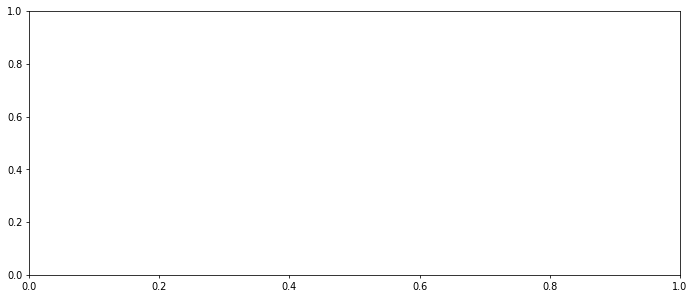

In [13]:
def running_mean(quantity):
    'return an array where the ith element is the mean of the first i values of the given array'
    return np.cumsum(quantity, axis = 0) / np.arange(1,quantity.shape[0]+1)

exacts = [Ff, Fc, Nf, Nc, Mf_moment[2], Mf_moment[4]]
print(exacts)
observables = [log.Ff, log.Fc,log.Nf,log.Nc,log.Mf_moments[2], log.Mf_moments[4]]
labels = ['Ff', 'Fc', 'Nf', 'Nc', 'M**2', 'M**4']

f, ax = plt.subplots(1,1, figsize = (12,5), sharex = 'all', gridspec_kw=dict(hspace = 0.5))

for x, label, exact in zip(observables, labels, exacts):
    ax.plot(np.arange(x.shape[0]), (running_mean(x)-exact)/exact * 100, label = label)

ax.plot((0,x.shape[0]),(0,0), 'k--')
ax.set(ylabel = '% deviation from expected value', xlim = (100,2000))
ax.legend()

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!

In [8]:
%%time
from direct_partition_functions import direct
from montecarlo import NfNc

beta = 1/2
U = 0
Js = [1,5]
mu = np.linspace(-5,5,30)
Ns = [2,4,6]
t = 1
alpha = 1.5
N_steps = 1000
N_burn_in = 100
normalise = True

def compute(m, **kwargs):
    return mcmc(mu=m,**kwargs)

data = np.zeros(shape = (len(Js), len(Ns), 6, len(mu)))

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for Jslice, J in zip(data, Js):
        for Nslice, N in zip(Jslice, Ns):
            #print(J, N)
            if N < 16:
                Ff, Fc, Nf, Nc, *Mf_moments = np.array([direct(system_size=N, mu=m,
                                                          beta=beta, U=U, J=J, t=t,
                                                          normalise = normalise) for m in mu]).T
            else:
                Nf, Nc = np.zeros((2,mu.shape[0]))

            curried = functools.partial(compute, state=np.zeros(shape=N), 
                    N_steps = N_steps, N_burn_in = N_burn_in, 
                    J=J, alpha=alpha, U=U, t=t,
                    logger=NfNc(), normalise = normalise)
                
            mc_Nf, mc_Nc, mc_dNf, mc_dNc = np.array(pool.map(curried, mu)).T
            
            np.copyto(Nslice, np.array([Nf, Nc, mc_Nf, mc_Nc, mc_dNf, mc_dNc]))

np.savez('./pickled_data/density_vs_mu.npz', 
         beta=beta, U=U, t=t, mu=mu, Ns=Ns, Js=Js, alpha=alpha, N_steps = N_steps, N_burn_in=N_burn_in,
        data=data, normalise=normalise,
        )
print('done')

Warning, p_acc = 0.7745454545454545, mu = -5.0, beta = 0.1, J = 1
Warning, p_acc = 0.7981818181818182, mu = -4.310344827586206, beta = 0.1, J = 1
Warning, p_acc = 0.8404545454545455, mu = -3.6206896551724137, beta = 0.1, J = 1
Warning, p_acc = 0.865909090909091, mu = -2.9310344827586206, beta = 0.1, J = 1
Warning, p_acc = 0.9036363636363637, mu = -2.2413793103448274, beta = 0.1, J = 1
Warning, p_acc = 0.9254545454545454, mu = -1.5517241379310343, beta = 0.1, J = 1
Warning, p_acc = 0.9540909090909091, mu = -0.8620689655172411, beta = 0.1, J = 1
Warning, p_acc = 0.7895454545454546, mu = -4.655172413793103, beta = 0.1, J = 1
Warning, p_acc = 0.8086363636363636, mu = -3.9655172413793105, beta = 0.1, J = 1
Warning, p_acc = 0.8472727272727273, mu = -3.275862068965517, beta = 0.1, J = 1
Warning, p_acc = 0.8790909090909091, mu = -2.586206896551724, beta = 0.1, J = 1
Warning, p_acc = 0.9031818181818182, mu = -1.8965517241379306, beta = 0.1, J = 1
Warning, p_acc = 0.9645454545454546, mu = -0.517

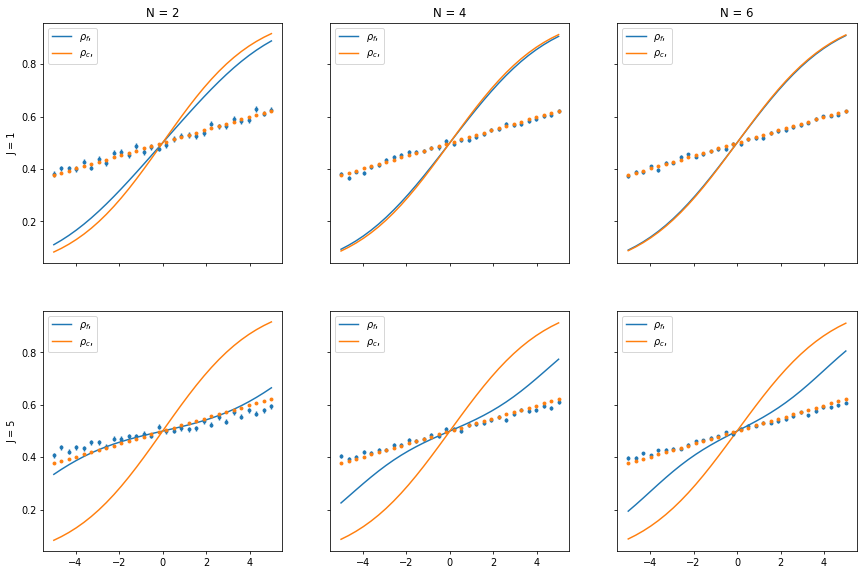

In [9]:
#%%time
data = np.load('./pickled_data/density_vs_mu.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for row, Jslice, J in zip(axes, data, Js):
    for ax, Nslice, N in zip(row, Jslice, Ns):
        Nf, Nc, mc_Nf, mc_Nc, mc_dNf, mc_dNc = Nslice

        Nt = (Nf + Nc) / 2
        
        #ax.plot(mu, Nt, label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        
        ax.plot(mu, Nf, label = r'$\rho_f$,', color = colors[0])
        ax.plot(mu, Nc, label = r'$\rho_c$,', color = colors[1])
        
        ax.errorbar(mu, mc_Nf, yerr = mc_dNf, fmt = '.', color = colors[0])
        ax.errorbar(mu, mc_Nc, yerr = mc_dNc, fmt = '.', color = colors[1])
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 

6 0 0
8 0 0
12 0 0
6 1 0
8 1 0
12 1 0
6 10 0
8 10 0
12 10 0
6 0 0.1
8 0 0.1
12 0 0.1
6 1 0.1
8 1 0.1
12 1 0.1
6 10 0.1
8 10 0.1
12 10 0.1
6 0 1
8 0 1
12 0 1
6 1 1
8 1 1
12 1 1
6 10 1
8 10 1
12 10 1
6 0 5
8 0 5
12 0 5
6 1 5
8 1 5
12 1 5
6 10 5
8 10 5
12 10 5
done
CPU times: user 54.7 s, sys: 3.79 s, total: 58.5 s
Wall time: 1min 34s


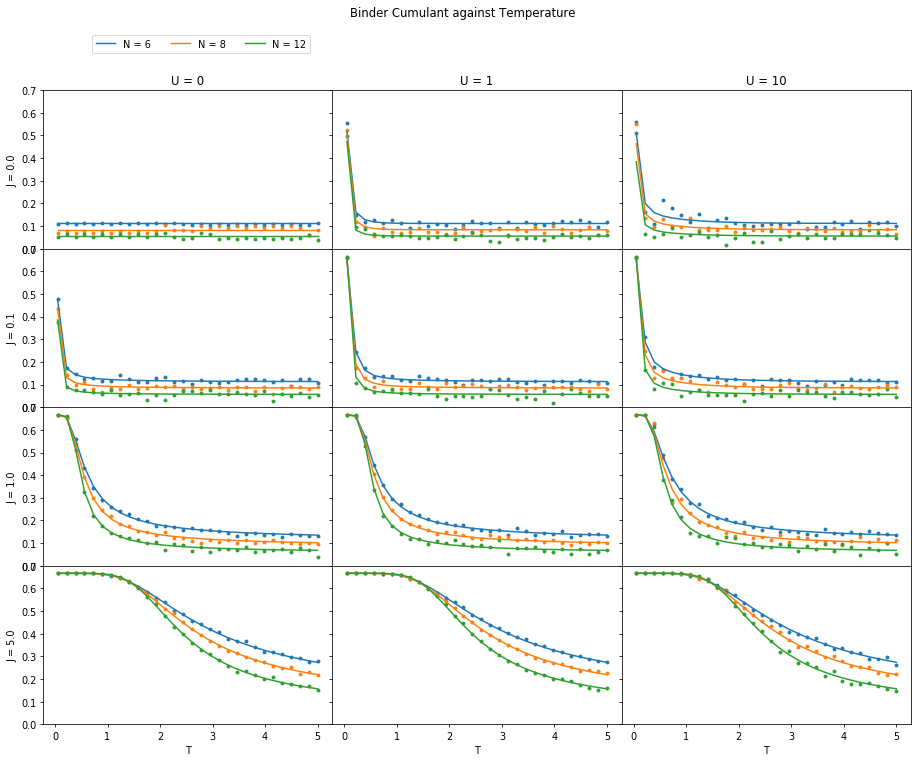

In [4]:
#%%time
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants, binder_cumulants, Js):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1, dir_slice1, Us):
        for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)
            
            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[i], = ax.plot(T, dir_binder_cumulant, label = f'N = {system_size}')    
            ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.set(ylim = (0, 0.7))
            
f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')
f.savefig('./Binder Cumulants.png')

In [ ]:
from itertools import count
data = np.load('./pickled_data/binder_cumulants_direct.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc.npz')
locals().update(data)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

J_i = [3,]
U_i = [2,]
f, axes = plt.subplots(len(J_i),len(U_i),figsize = (len(J_i)*7,len(U_i)*7), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0), squeeze = False)

for row, mc_slice1, dir_slice1, J in zip(axes, mcmc_binder_cumulants[J_i], binder_cumulants[J_i], Js[J_i]):
    for ax, mc_slice2, dir_slice2, U in zip(row, mc_slice1[U_i], dir_slice1[U_i], Us[U_i]):        
        for i, mc_slice3, dir_slice3, system_size in zip(count(), mc_slice2, dir_slice2, Ns):
            dir_Mf_moments, dir_Mf_central_moments = dir_slice3
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3

            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

            dir_binder_cumulant = binder_cumulant(dir_Mf_central_moments)
            lines[i], = ax.plot(T, dir_binder_cumulant, label = f'N = {system_size}')    
            ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.')    
            ax.set(ylim = (0, 0.7))
            
f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

for ax,U in zip(axes[0],Us[U_i]): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js[J_i]): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')